In [ ]:
#Module Imports
from __future__ import print_function
import random
from os import listdir
import glob

import numpy as np
import pandas as pd
from scipy import misc
import tensorflow as tf
import h5py
import statistics 

from keras.datasets import mnist
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPool2D
from keras.layers.normalization import BatchNormalization


# Process MNIST Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
# Open file
hf = h5py.File(path + 'MNIST_synthetic.h5', 'r')

In [ ]:
# Store the datasets
train_dataset = np.squeeze(np.array(hf["train_dataset"])).copy()
test_dataset = np.squeeze(np.array(hf["test_dataset"])).copy()
train_labels = np.squeeze(np.array(hf["train_labels"])).copy()

# Close the file
hf.close()

Shape of training dataset: (56000, 64, 64)
Shape of test dataset: (14000, 64, 64)
Shape of training labels: (56000, 5)
Label for image: [ 8  5  0  3 10]


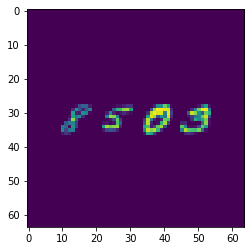

In [ ]:
# Checking the dataset
print("Shape of training dataset: {}".format(np.shape(train_dataset)))
print("Shape of test dataset: {}".format(np.shape(test_dataset)))
print("Shape of training labels: {}".format(np.shape(train_labels)))

plt.figure()
plt.imshow(train_dataset[0])

print("Label for image: {}".format(train_labels[0]))

In [ ]:
train_dataset = train_dataset.reshape([-1, 64, 64, 1])
test_dataset = test_dataset.reshape([-1, 64, 64, 1])

In [ ]:
print(train_dataset.shape)

(56000, 64, 64, 1)


In [ ]:
print(test_dataset.shape)

(14000, 64, 64, 1)


In [ ]:
print(train_labels)

[[ 8  5  0  3 10]
 [ 8  9  9  8  7]
 [ 1  7  9  1  8]
 ...
 [ 4  4 10 10 10]
 [ 7  9  8 10 10]
 [ 6 10 10 10 10]]


In [ ]:
#Conver labels to One-hot representation of shape (set_Size, digits, classes)
#Possible Classes are 11 because there are 0-9 digits and another class to represent that no number was there hence 11 classes
possible_classes = 11

def convert_labels(labels):
  dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
  dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
  dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
  dig3_arr = np.ndarray(shape=(len(labels),possible_classes)) 
  dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
  for index, label in enumerate(labels):
    dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
    dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
    dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
    dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
    dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)

  return [dig0_arr, dig1_arr, dig2_arr, dig3_arr, dig4_arr]

In [ ]:
print(np.shape(train_labels))
train_labels_test = train_labels.copy()
train_labels = convert_labels(train_labels)

print(np.shape(train_labels))

(56000, 5)
(5, 56000, 11)


In [ ]:
# CREATE VALIDATION SET

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(train_dataset, train_labels_test, test_size = 0.333)

In [ ]:
Y_train = convert_labels(Y_train)
Y_val = convert_labels(Y_val)

In [ ]:
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# Find Best Dense Layer

In [ ]:
# Model Building

nets = 8
model = [0] *nets

# Construct 8 models with different Dense layer 
for j in range(8):

  inputs = Input(shape=(64, 64, 1))

  cov = Convolution2D(32,kernel_size=3,activation='relu')(inputs)
  cov = BatchNormalization()(cov)
  cov = Convolution2D(32,kernel_size=3,activation='relu')(cov)
  cov = BatchNormalization()(cov)
  cov = Convolution2D(32,kernel_size=5,strides=2,padding='same',activation='relu')(cov)
  cov = BatchNormalization()(cov)
  cov = Dropout(0.4)(cov)

  cov = Convolution2D(64,kernel_size=3,activation='relu')(cov)
  cov = BatchNormalization()(cov)
  cov = Convolution2D(64,kernel_size=3,activation='relu')(cov)
  cov = BatchNormalization()(cov)
  cov = Convolution2D(64,kernel_size=5,strides=2,padding='same',activation='relu')(cov)
  cov = BatchNormalization()(cov)
  cov = Dropout(0.4)(cov)

  cov = Flatten()(cov)
  cov = Dense(2**(j+2), activation='relu')(cov)
  cov = BatchNormalization()(cov)
  cov = Dropout(0.4)(cov)

  # Define five output of the label
  c0 = Dense(11, activation='softmax')(cov)
  c1 = Dense(11, activation='softmax')(cov)
  c2 = Dense(11, activation='softmax')(cov)
  c3 = Dense(11, activation='softmax')(cov)
  c4 = Dense(11, activation='softmax')(cov)

  # Comple the model
  model[j] = Model(inputs=inputs, outputs=[c0, c1, c2, c3, c4])
  model[j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
cu r v# epochs=15
# model.fit(train_dataset, train_labels, batch_size=64, epochs = epochs, verbose=1)

history = [0] * nets
result = [0] * nets
train_acc = []
val_acc = []

# experiment on different dense layer
names = ["4N","8N","16N","32N","64N","128N","256N","512N"]

# set epoches
epochs = 15

# train models with loop
for j in range(nets):
    history[j] = model[j].fit(X_train, Y_train, batch_size=64, epochs = epochs, 
                              validation_data = (X_val,Y_val), callbacks=[annealer], verbose=0)

In [ ]:
for j in range(nets):
    result[j] = pd.DataFrame.from_dict(history[j].history)
    # collect accuracy
    val_acc.append(statistics.mean(result[j].iloc[:,20]))
    train_acc.append(statistics.mean(result[j].iloc[:,10]))
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,statistics.mean(result[j].iloc[:,10]),statistics.mean(result[j].iloc[:,20])))

CNN 4N: Epochs=15, Train accuracy=0.81316, Validation accuracy=0.64286
CNN 8N: Epochs=15, Train accuracy=0.81966, Validation accuracy=0.71724
CNN 16N: Epochs=15, Train accuracy=0.82365, Validation accuracy=0.82518
CNN 32N: Epochs=15, Train accuracy=0.87021, Validation accuracy=0.99592
CNN 64N: Epochs=15, Train accuracy=0.97398, Validation accuracy=0.99796
CNN 128N: Epochs=15, Train accuracy=0.99502, Validation accuracy=0.99861
CNN 256N: Epochs=15, Train accuracy=0.99810, Validation accuracy=0.99866
CNN 512N: Epochs=15, Train accuracy=0.99888, Validation accuracy=0.99780


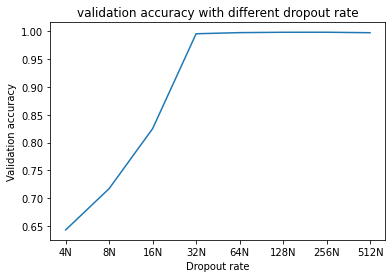

In [ ]:
plt.plot(names, val_acc)
plt.title('validation accuracy with different dense layer')
plt.ylabel('Validation accuracy')
plt.xlabel('Dense layer')
plt.show()

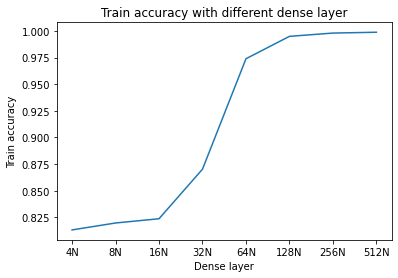

In [ ]:
plt.plot(names, train_acc)
plt.title('Train accuracy with different dense layer')
plt.ylabel('Train accuracy')
plt.xlabel('Dense layer')
plt.show()

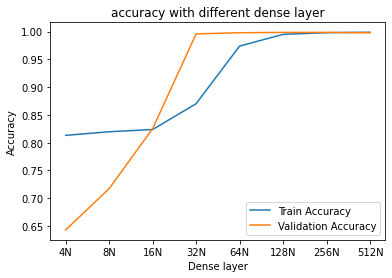

In [ ]:
plt.title('accuracy with different dense layer')

plt.plot(names,train_acc,label='Train Accuracy')

plt.plot(names,val_acc,label='Validation Accuracy')

plt.legend()
plt.xlabel('Dense layer')
plt.ylabel('Accuracy')
plt.show()

# Find Best Batch Size

In [ ]:
# Model Building

inputs = Input(shape=(64, 64, 1))

cov = Convolution2D(32,kernel_size=3,activation='relu')(inputs)
cov = BatchNormalization()(cov)
cov = Convolution2D(32,kernel_size=3,activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Convolution2D(32,kernel_size=5,strides=2,padding='same',activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Dropout(0.4)(cov)

cov = Convolution2D(64,kernel_size=3,activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Convolution2D(64,kernel_size=3,activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Convolution2D(64,kernel_size=5,strides=2,padding='same',activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Dropout(0.4)(cov)

cov = Flatten()(cov)
cov = Dense(128, activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Dropout(0.4)(cov)

c0 = Dense(11, activation='softmax')(cov)
c1 = Dense(11, activation='softmax')(cov)
c2 = Dense(11, activation='softmax')(cov)
c3 = Dense(11, activation='softmax')(cov)
c4 = Dense(11, activation='softmax')(cov)

model = Model(inputs=inputs, outputs=[c0, c1, c2, c3, c4])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    

In [ ]:
# Fit the model 8 rounds with different batch size
round = 8

history = [0] * round
result = [0] * round
val_acc = []
train_acc = []
# experiment on different batch size
names = ["4","8","16","32","64","128","256","512"]

# set epoches
epochs = 15

# train models with loop
for j in range(round):
    batch_size = 2**(j+2)
    history[j] = model.fit(X_train, Y_train, batch_size=batch_size, epochs = epochs, 
                              validation_data = (X_val,Y_val), callbacks=[annealer], verbose=0)

In [ ]:
for j in range(round):
    result[j] = pd.DataFrame.from_dict(history[j].history)
    # collect accuracy
    val_acc.append(statistics.mean(result[j].iloc[:,20]))
    train_acc.append(statistics.mean(result[j].iloc[:,10]))
    print("Batch size {0}: Epoch={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,statistics.mean(result[j].iloc[:,10]),statistics.mean(result[j].iloc[:,20])))

Batch size 4: Epoch=15, Train accuracy=0.95975, Validation accuracy=0.96325
Batch size 8: Epoch=15, Train accuracy=0.99271, Validation accuracy=0.99807
Batch size 16: Epoch=15, Train accuracy=0.99746, Validation accuracy=0.93259
Batch size 32: Epoch=15, Train accuracy=0.99871, Validation accuracy=0.97124
Batch size 64: Epoch=15, Train accuracy=0.99916, Validation accuracy=0.99926
Batch size 128: Epoch=15, Train accuracy=0.99939, Validation accuracy=0.99919
Batch size 256: Epoch=15, Train accuracy=0.99952, Validation accuracy=0.99921
Batch size 512: Epoch=15, Train accuracy=0.99959, Validation accuracy=0.99927


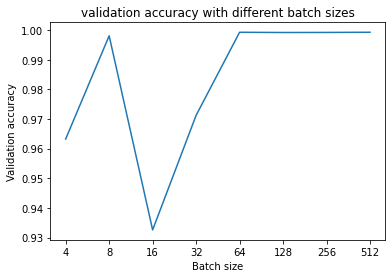

In [ ]:
plt.plot(names, val_acc)
plt.title('validation accuracy with different batch sizes')
plt.ylabel('Validation accuracy')
plt.xlabel('Batch size')
plt.show()

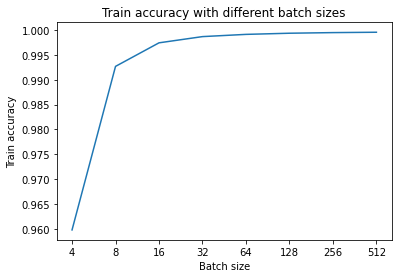

In [ ]:
plt.plot(names, train_acc)
plt.title('Train accuracy with different batch sizes')
plt.ylabel('Train accuracy')
plt.xlabel('Batch size')
plt.show()

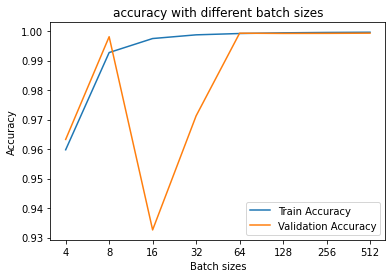

In [ ]:
plt.title('accuracy with different batch sizes')

plt.plot(names,train_acc,label='Train Accuracy')

plt.plot(names,val_acc,label='Validation Accuracy')

plt.legend()
plt.xlabel('Batch sizes')
plt.ylabel('Accuracy')
plt.show()

# Find Best Dropout Rate

In [ ]:
## testing dropout

# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 8
model = [0] *nets

for j in range(8):
    inputs = Input(shape=(64, 64, 1))

    cov = Convolution2D(32,kernel_size=3,activation='relu')(inputs)
    cov = BatchNormalization()(cov)
    cov = Convolution2D(32,kernel_size=3,activation='relu')(cov)
    cov = BatchNormalization()(cov)
    cov = Convolution2D(32,kernel_size=5,strides=2,padding='same',activation='relu')(cov)
    cov = BatchNormalization()(cov)
    cov = Dropout(j*0.1)(cov)

    cov = Convolution2D(64,kernel_size=3,activation='relu')(cov)
    cov = BatchNormalization()(cov)
    cov = Convolution2D(64,kernel_size=3,activation='relu')(cov)
    cov = BatchNormalization()(cov)
    cov = Convolution2D(64,kernel_size=5,strides=2,padding='same',activation='relu')(cov)
    cov = BatchNormalization()(cov)
    cov = Dropout(j*0.1)(cov)

    cov = Flatten()(cov)
    cov = Dense(128, activation='relu')(cov)
    cov = BatchNormalization()(cov)
    cov = Dropout(j*0.1)(cov)
    #cov = Dense(11, activation='softmax')(cov)

    c0 = Dense(11, activation='softmax')(cov)
    c1 = Dense(11, activation='softmax')(cov)
    c2 = Dense(11, activation='softmax')(cov)
    c3 = Dense(11, activation='softmax')(cov)
    c4 = Dense(11, activation='softmax')(cov)

    model[j] = Model(inputs=inputs, outputs=[c0, c1, c2, c3, c4])
    model[j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# TRAIN NETWORKS
import pandas as pd
history = [0]*nets
result = [0]*nets
val_acc=[]
train_acc=[]
names = ["D=0","D=0.1","D=0.2","D=0.3","D=0.4","D=0.5","D=0.6","D=0.7"]
epochs = 15
for j in range(nets):
    history[j] = model[j].fit(X_train, Y_train, batch_size=64, epochs = epochs, validation_data = (X_val,Y_val), callbacks=[annealer], 
                              verbose=0)

In [ ]:
for j in range(nets):
    result[j] = pd.DataFrame.from_dict(history[j].history)
    # collect accuracy
    val_acc.append(statistics.mean(result[j].iloc[:,20]))
    train_acc.append(statistics.mean(result[j].iloc[:,10]))
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,statistics.mean(result[j].iloc[:,10]),statistics.mean(result[j].iloc[:,20])))

CNN D=0: Epochs=15, Train accuracy=0.99663, Validation accuracy=0.44632
CNN D=0.1: Epochs=15, Train accuracy=0.99533, Validation accuracy=0.47902
CNN D=0.2: Epochs=15, Train accuracy=0.99329, Validation accuracy=0.60691
CNN D=0.3: Epochs=15, Train accuracy=0.98942, Validation accuracy=0.56764
CNN D=0.4: Epochs=15, Train accuracy=0.98260, Validation accuracy=0.84676
CNN D=0.5: Epochs=15, Train accuracy=0.97415, Validation accuracy=0.67360
CNN D=0.6: Epochs=15, Train accuracy=0.94254, Validation accuracy=0.83382
CNN D=0.7: Epochs=15, Train accuracy=0.92005, Validation accuracy=0.88521


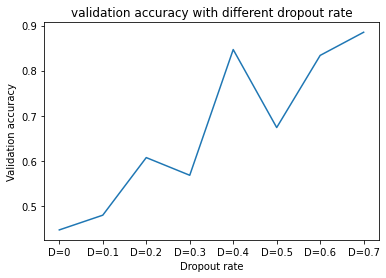

In [ ]:
plt.plot(names, val_acc)
plt.title('validation accuracy with different dropout rate')
plt.ylabel('Validation accuracy')
plt.xlabel('Dropout rate')
plt.show()

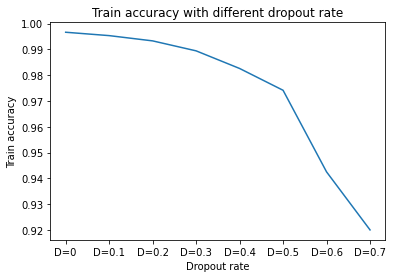

In [ ]:
plt.plot(names, train_acc)
plt.title('Train accuracy with different dropout rate')
plt.ylabel('Train accuracy')
plt.xlabel('Dropout rate')
plt.show()

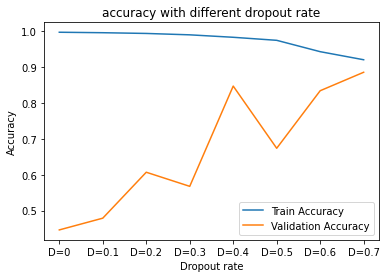

In [ ]:
plt.title('accuracy with different dropout rate')

plt.plot(names,train_acc,label='Train Accuracy')

plt.plot(names,val_acc,label='Validation Accuracy')

plt.legend()
plt.xlabel('Dropout rate')
plt.ylabel('Accuracy')
plt.show()

# Find Best Filter Number

In [ ]:
## testing feature map

nets = 6
model = [0] *nets
for j in range(6):   
   
    inputs = Input(shape=(64, 64, 1))

    cov = Convolution2D(j*8+8,kernel_size=3,activation='relu')(inputs)
    cov = BatchNormalization()(cov)
    cov = Convolution2D(j*8+8,kernel_size=3,activation='relu')(cov)
    cov = BatchNormalization()(cov)
    cov = Convolution2D(j*8+8,kernel_size=5,strides=2,padding='same',activation='relu')(cov)
    cov = BatchNormalization()(cov)
    cov = Dropout(0.4)(cov)

    cov = Convolution2D(j*16+16,kernel_size=3,activation='relu')(cov)
    cov = BatchNormalization()(cov)
    cov = Convolution2D(j*16+16,kernel_size=3,activation='relu')(cov)
    cov = BatchNormalization()(cov)
    cov = Convolution2D(j*16+16,kernel_size=5,strides=2,padding='same',activation='relu')(cov)
    cov = BatchNormalization()(cov)
    cov = Dropout(0.4)(cov)

    cov = Flatten()(cov)
    cov = Dense(128, activation='relu')(cov)
    cov = BatchNormalization()(cov)
    cov = Dropout(0.4)(cov)
    #cov = Dense(11, activation='softmax')(cov)

    c0 = Dense(11, activation='softmax')(cov)
    c1 = Dense(11, activation='softmax')(cov)
    c2 = Dense(11, activation='softmax')(cov)
    c3 = Dense(11, activation='softmax')(cov)
    c4 = Dense(11, activation='softmax')(cov)

    model[j] = Model(inputs=inputs, outputs=[c0, c1, c2, c3, c4])
    model[j].compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# TRAIN NETWORKS
import pandas as pd
history = [0]*nets
result = [0]*nets
val_acc=[]
train_acc=[]
names = ["8 maps","16 maps","24 maps","32 maps","48 maps","64 maps"]
epochs = 15
for j in range(nets):
    history[j] = model[j].fit(X_train, Y_train, batch_size=64, epochs = epochs, validation_data = (X_val,Y_val), callbacks=[annealer], 
                              verbose=0)

In [ ]:
for j in range(nets):
    result[j] = pd.DataFrame.from_dict(history[j].history)
    # collect accuracy
    val_acc.append(statistics.mean(result[j].iloc[:,20]))
    train_acc.append(statistics.mean(result[j].iloc[:,10]))
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        names[j],epochs,statistics.mean(result[j].iloc[:,10]),statistics.mean(result[j].iloc[:,20])))

CNN 8 maps: Epochs=15, Train accuracy=0.96087, Validation accuracy=0.88523
CNN 16 maps: Epochs=15, Train accuracy=0.97284, Validation accuracy=0.60673
CNN 24 maps: Epochs=15, Train accuracy=0.98041, Validation accuracy=0.62742
CNN 32 maps: Epochs=15, Train accuracy=0.98256, Validation accuracy=0.80036
CNN 48 maps: Epochs=15, Train accuracy=0.98357, Validation accuracy=0.76375
CNN 64 maps: Epochs=15, Train accuracy=0.98579, Validation accuracy=0.59838


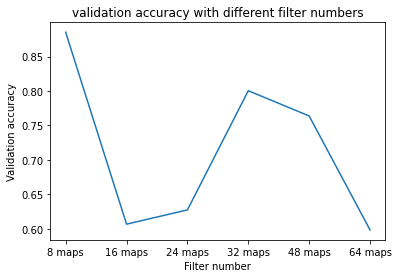

In [ ]:
plt.plot(names, val_acc)
plt.title('validation accuracy with different filter numbers')
plt.ylabel('Validation accuracy')
plt.xlabel('Filter number')
plt.show()

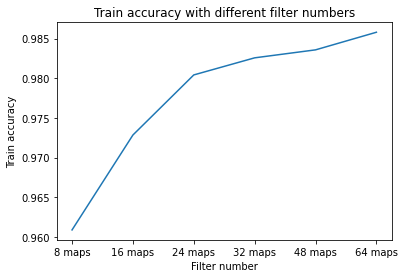

In [ ]:
plt.plot(names, train_acc)
plt.title('Train accuracy with different filter numbers')
plt.ylabel('Train accuracy')
plt.xlabel('Filter number')
plt.show()

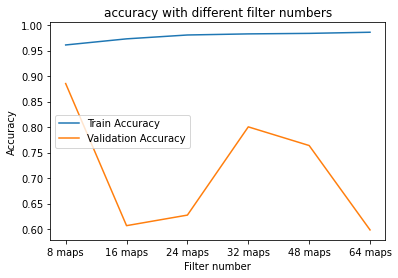

In [ ]:
plt.title('accuracy with different filter numbers')

plt.plot(names,train_acc,label='Train Accuracy')

plt.plot(names,val_acc,label='Validation Accuracy')

plt.legend()
plt.xlabel('Filter number')
plt.ylabel('Accuracy')
plt.show()

# Best model


In [ ]:
inputs = Input(shape=(64, 64, 1))

cov = Convolution2D(32,kernel_size=3,activation='relu')(inputs)
cov = BatchNormalization()(cov)
cov = Convolution2D(32,kernel_size=3,activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Convolution2D(32,kernel_size=5,strides=2,padding='same',activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Dropout(0.4)(cov)

cov = Convolution2D(64,kernel_size=3,activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Convolution2D(64,kernel_size=3,activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Convolution2D(64,kernel_size=5,strides=2,padding='same',activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Dropout(0.4)(cov)

cov = Flatten()(cov)
cov = Dense(64, activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Dropout(0.4)(cov)
#cov = Dense(11, activation='softmax')(cov)

c0 = Dense(11, activation='softmax')(cov)
c1 = Dense(11, activation='softmax')(cov)
c2 = Dense(11, activation='softmax')(cov)
c3 = Dense(11, activation='softmax')(cov)
c4 = Dense(11, activation='softmax')(cov)

model = Model(inputs=inputs, outputs=[c0, c1, c2, c3, c4])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(train_dataset, train_labels, batch_size=8, epochs = 50, 
                              verbose=0)

# Generate Prediction Result

In [ ]:
# Generate Prediction Result
predictions = model.predict(test_dataset)

In [ ]:
model.evaluate(train_dataset, train_labels)

1750/1750 [==============================] - 11s 6ms/step - loss: 0.0099 - dense_145_loss: 0.0048 - dense_146_loss: 0.0021 - dense_147_loss: 0.0016 - dense_148_loss: 8.4241e-04 - dense_149_loss: 4.1481e-04 - dense_145_accuracy: 0.9989 - dense_146_accuracy: 0.9994 - dense_147_accuracy: 0.9995 - dense_148_accuracy: 0.9997 - dense_149_accuracy: 0.9999


[0.009857000783085823,
 0.004828264005482197,
 0.0021443525329232216,
 0.0016271614003926516,
 0.00084241310833022,
 0.0004148139269091189,
 0.9989107251167297,
 0.9993571639060974,
 0.9995178580284119,
 0.9996607303619385,
 0.9998928308486938]

In [ ]:
#A function which return the predicted digit

def predict_image(image):
  plt.imshow(np.resize(image, (64, 64)))
  plt.show()
  image = image.reshape(1, 64, 64, 1)
  prediction = model.predict(image)
  for i in range(5):
    prediction[i] = np.argmax(prediction[i])
  a = []
  for i in prediction:
    if i!=10:
      a.append(i)
  print('Predicted Value is', ''.join(map(str, a)))

In [ ]:
#Print the prediction result into CSV file

from csv import writer
def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)

import csv
#with open('result.csv', 'w', newline='') as csvfile:
row_contents = ['Id','Label']
append_list_as_row('result.csv', row_contents)

for i in range(0,14000):   
    predicted_labels = []   
    for j in range(0,5):
        predicted_labels.append(np.argmax(predictions[j][i]))
    print('index', i)
    #predict_image(test_dataset[i])
    s = [str(i) for i in predicted_labels]
    result = s[0] + s[1] + s[2] + s[3] + s[4]
    print(result)
    print("Predicted labels: {}\n".format(predicted_labels))
    row_contents = [i,result]
    print(row_contents)
    append_list_as_row('result.csv', row_contents)

Streaming output truncated to the last 5000 lines.
index 13000
730410
Predicted labels: [7, 3, 0, 4, 10]

[13000, '730410']
index 13001
944910
Predicted labels: [9, 4, 4, 9, 10]

[13001, '944910']
index 13002
710101010
Predicted labels: [7, 10, 10, 10, 10]

[13002, '710101010']
index 13003
610101010
Predicted labels: [6, 10, 10, 10, 10]

[13003, '610101010']
index 13004
92589
Predicted labels: [9, 2, 5, 8, 9]

[13004, '92589']
index 13005
385610
Predicted labels: [3, 8, 5, 6, 10]

[13005, '385610']
index 13006
3641010
Predicted labels: [3, 6, 4, 10, 10]

[13006, '3641010']
index 13007
1781010
Predicted labels: [1, 7, 8, 10, 10]

[13007, '1781010']
index 13008
24101010
Predicted labels: [2, 4, 10, 10, 10]

[13008, '24101010']
index 13009
610101010
Predicted labels: [6, 10, 10, 10, 10]

[13009, '610101010']
index 13010
4391010
Predicted labels: [4, 3, 9, 10, 10]

[13010, '4391010']
index 13011
8371010
Predicted labels: [8, 3, 7, 10, 10]

[13011, '8371010']
index 13012
32032
Predicted lab

index 4427


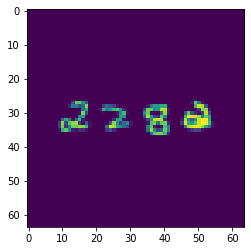

Predicted Value is 2282
Predicted labels: [2, 2, 8, 2, 10]

index 8038


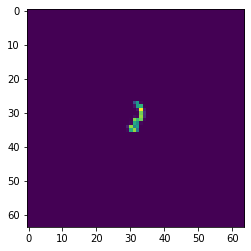

Predicted Value is 3
Predicted labels: [3, 10, 10, 10, 10]

index 770


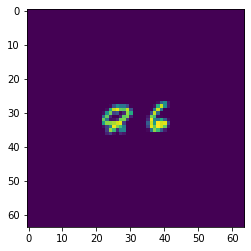

Predicted Value is 86
Predicted labels: [8, 6, 10, 10, 10]

index 7012


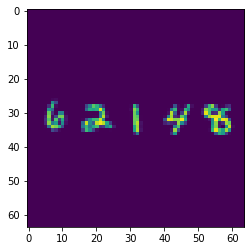

Predicted Value is 62148
Predicted labels: [6, 2, 1, 4, 8]

index 9037


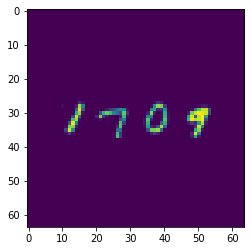

Predicted Value is 1709
Predicted labels: [1, 7, 0, 9, 10]



In [ ]:
#Printing some examples of real and predicted labels
for i in random.sample(range(0,10000),5):
    
    predicted_labels = []
    
    for j in range(0,5):
        predicted_labels.append(np.argmax(predictions[j][i]))
    print('index', i)
    predict_image(test_dataset[i])
    print("Predicted labels: {}\n".format(predicted_labels))

# Compare the performance for CPU and GPU
the data is manully inputed since it is hard to run CPU and GPU at the same time.

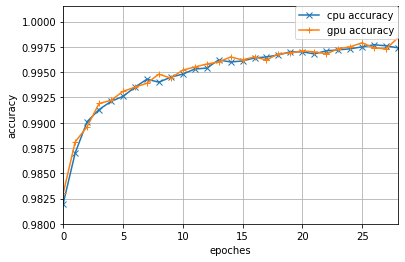

In [ ]:
import matplotlib.pyplot as plt
 #1410s/epoch for cpu and about 30s/epoch for gpu
cpu_accuracy = [0.9820, 0.9870, 0.9901, 0.9913, 0.9921, 0.9926, 0.9935, 0.9943, 0.9940, 0.9945, 0.9948, 0.9953, 0.9954, 0.9962, 0.9960, 0.9961, 0.9964, 0.9965, 0.9967, 0.9970, 0.9970, 0.9968, 0.9971,0.9972, 0.9973, 0.9975, 0.9977, 0.9976, 0.9974]
gpu_accuracy = [0.9830, 0.9881, 0.9896, 0.9919, 0.9922, 0.9931, 0.9935, 0.9939, 0.9948, 0.9944, 0.9952, 0.9955, 0.9958, 0.9960, 0.9965, 0.9962, 0.9965, 0.9962, 0.9968, 0.9969, 0.9971, 0.9970, 0.9968, 0.9973, 0.9975, 0.9979, 0.9974, 0.9973, 0.9984]
 
fig,ax = plt.subplots()
 
plt.xlabel('epoches')
plt.ylabel('accuracy')

ax.set_ylim([0.98,1.0015])
ax.set_xlim([0,28])
 
plt.plot(cpu_accuracy,"x-", label="cpu accuracy")
plt.plot(gpu_accuracy,"+-", label="gpu accuracy")

plt.grid(True)
plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)
plt.show()

# Training and Validation Accuracy for Epoch

In [ ]:
inputs = Input(shape=(64, 64, 1))

cov = Convolution2D(32,kernel_size=3,activation='relu')(inputs)
cov = BatchNormalization()(cov)
cov = Convolution2D(32,kernel_size=3,activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Convolution2D(32,kernel_size=5,strides=2,padding='same',activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Dropout(0.4)(cov)

cov = Convolution2D(64,kernel_size=3,activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Convolution2D(64,kernel_size=3,activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Convolution2D(64,kernel_size=5,strides=2,padding='same',activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Dropout(0.4)(cov)

cov = Flatten()(cov)
cov = Dense(128, activation='relu')(cov)
cov = BatchNormalization()(cov)
cov = Dropout(0.4)(cov)
#cov = Dense(11, activation='softmax')(cov)

c0 = Dense(11, activation='softmax')(cov)
c1 = Dense(11, activation='softmax')(cov)
c2 = Dense(11, activation='softmax')(cov)
c3 = Dense(11, activation='softmax')(cov)
c4 = Dense(11, activation='softmax')(cov)

model = Model(inputs=inputs, outputs=[c0, c1, c2, c3, c4])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# TRAIN NETWORKS
history = []
history = model.fit(X_train, Y_train, batch_size=64, epochs = 60, validation_data = (X_val,Y_val),
                              verbose=1)

Epoch 1/60
584/584 [==============================] - 22s 37ms/step - loss: 0.4599 - dense_1_loss: 0.1270 - dense_2_loss: 0.1261 - dense_3_loss: 0.1045 - dense_4_loss: 0.0641 - dense_5_loss: 0.0382 - dense_1_accuracy: 0.9647 - dense_2_accuracy: 0.9636 - dense_3_accuracy: 0.9700 - dense_4_accuracy: 0.9818 - dense_5_accuracy: 0.9897 - val_loss: 872.4814 - val_dense_1_loss: 208.6840 - val_dense_2_loss: 272.0326 - val_dense_3_loss: 106.8828 - val_dense_4_loss: 243.3143 - val_dense_5_loss: 41.5680 - val_dense_1_accuracy: 0.1164 - val_dense_2_accuracy: 0.0758 - val_dense_3_accuracy: 0.3987 - val_dense_4_accuracy: 0.0368 - val_dense_5_accuracy: 0.8005
Epoch 2/60
584/584 [==============================] - 22s 37ms/step - loss: 0.3836 - dense_1_loss: 0.1071 - dense_2_loss: 0.1021 - dense_3_loss: 0.0853 - dense_4_loss: 0.0530 - dense_5_loss: 0.0361 - dense_1_accuracy: 0.9692 - dense_2_accuracy: 0.9708 - dense_3_accuracy: 0.9753 - dense_4_accuracy: 0.9847 - dense_5_accuracy: 0.9904 - val_loss: 12

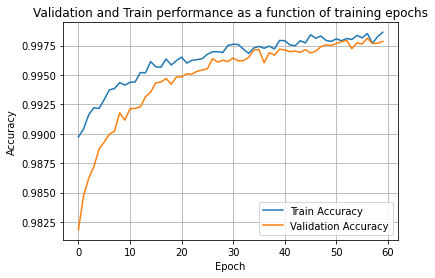

In [ ]:
plt.title('Validation and Train performance as a function of training epochs')

X = [i for i in range(len(history.history['dense_5_accuracy']))]
plt.plot(X,history.history['dense_5_accuracy'],label='Train Accuracy')

X2 = [i for i in range(len(history.history['dense_4_accuracy']))]
plt.plot(X2,history.history['dense_4_accuracy'],label='Validation Accuracy')

plt.grid(True)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()